## Overview:

- Goal: Try to use HF repos (<50GB per file is allowed) and GridFS of MongoDB (keeping datachunks in its own shape, avoid merging and splitting loops, making version control become possible)

Steps:
- 1. Create 10 JSONs to simulate we are manipulating big data chunks
- 2. Connect each components and make first commit
- 3. Update the database/collection and then make second commit to see whether version control is working. 

Figure: 
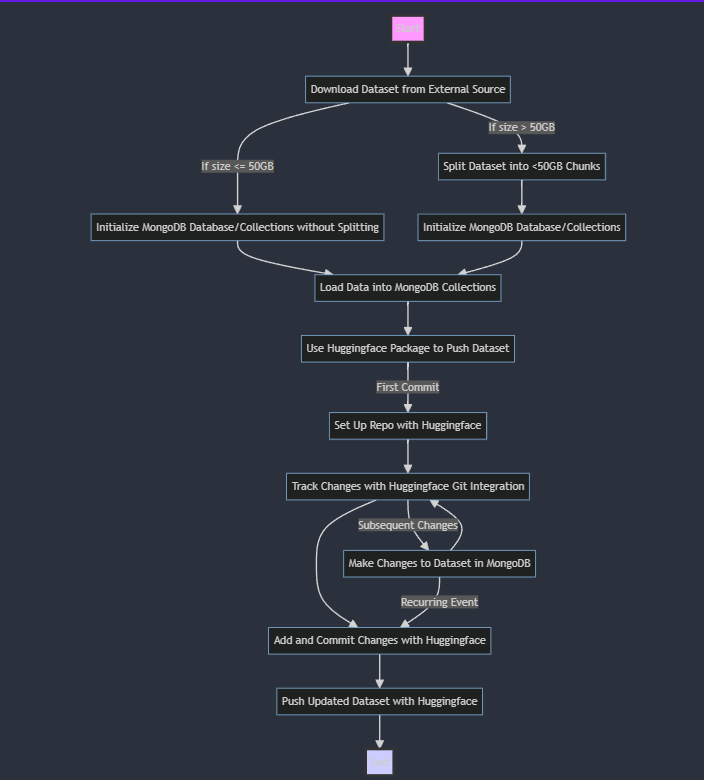

Importing packages: 

In [ ]:
import gridfs
import pymongo
from pymongo import MongoClient
from huggingface_hub import Repository
import os
import io
import json
from bson import ObjectId

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

## Step 1: Create 10 sample JSON document (each of them mimics a <50DB data chunk)

In [ ]:
# Set the directory name where the JSON documents will be saved
dataset_directory = 'dataset'

# Function to generate and save JSON documents
def generate_json_documents(directory, num_docs):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in range(num_docs):
        sample_data = {
            'document_id': i,
            'text': f"This is sample text for document {i}.",
            'value': i
        }
        file_name = f"document_{i}.json"
        file_path = os.path.join(directory, file_name)
        with open(file_path, 'w') as json_file:
            json.dump(sample_data, json_file)
    print(f"{num_docs} JSON documents have been saved to the '{directory}' folder.")
    
# Generate 10 JSON documents
generate_json_documents(dataset_directory, 10)

## Step 2: Use MongoDB + GridFS + PySpark, to load these document chunks, without combining them

In [ ]:
# Initialize PySpark session
spark = SparkSession.builder \
    .appName("GridFS PySpark Processor") \
    .getOrCreate()

# MongoDB client and GridFS setup
client = MongoClient()
db = client['gridfs_large_files']
fs = gridfs.GridFS(db)

# Function to load JSON files to GridFS
def load_json_to_gridfs(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'rb') as f:
                file_id = fs.put(f, filename=filename)
                print(f"File {filename} uploaded to GridFS with file id {file_id}")

# Load JSON documents to GridFS
load_json_to_gridfs(dataset_directory)

# Close the Spark session
spark.stop()

## Step 3: Commit dataset repo into huggingface dataset repo

In [ ]:
# Initialize Hugging Face repository

# Define your variables outside the function
repo_name = "dataset-repo-name"
namespace = "your-hf-namespace"
auth_token = "your-hf-token"

# Retrieve files from GridFS and save them in the repository directory
def retrieve_files_from_gridfs_and_save(fs, local_dir):
    for grid_out in fs.find():
        file_path = os.path.join(local_dir, grid_out.filename)
        with open(file_path, 'wb') as f:
            f.write(grid_out.read())

# Function to commit files from GridFS to a Hugging Face repository
def commit_files_to_hf(fs, repo_name, namespace, auth_token, commit_message):
    # Construct the repository URL using the namespace and repository name
    repo_url = f"{namespace}/{repo_name}"
    
    # Clone the Hugging Face repository using the auth token
    repo = Repository(local_dir="hf_repo", clone_from=repo_url, use_auth_token=auth_token)
    
    # Pull the latest changes from the repository
    repo.git_pull()
    
    # Retrieve files from GridFS and save them in the repository directory
    for grid_out in fs.find():
        file_path = os.path.join(repo.local_dir, grid_out.filename)
        with open(file_path, 'wb') as f:
            f.write(grid_out.read())

    # Retrieve files from GridFS
    retrieve_files_from_gridfs_and_save(fs, repo.local_dir)
    
    # Add all files to the repo and commit
    repo.git_add(auto_lfs_track=True)
    repo.git_commit(commit_message)
    repo.git_push()

# Commit the initial files to Hugging Face repository
commit_files_to_hf(fs, repo_name, namespace,auth_token, "Initial commit with MongoDB GridFS files")

## Step 4: Update the whole database, and then try to commit change to huggingface repo

In [ ]:
# Function for updating all documents in GridFS
def process_and_update_gridfs_documents(fs, spark):
    for grid_out in fs.find():
        # Convert the GridFS file content into a format that PySpark can read (e.g., StringIO)
        content = io.StringIO(grid_out.read().decode('utf-8'))
        
        # Read the content using PySpark
        pdf = spark.read.json(content)
        
        # Example PySpark processing (increment the 'value' field by 1)
        pdf = pdf.withColumn("value", col("value") + 1)
        
        # Convert the processed PySpark DataFrame back to JSON
        processed_data_json = pdf.toJSON().collect()[0]
        
        # Update the document in GridFS
        fs.delete(grid_out._id)  # Delete the old document
        fs.put(processed_data_json, filename=grid_out.filename)  # Store the new document

        # Convert the processed PySpark DataFrame back to a list of JSON strings
        processed_data_json_list = pdf.toJSON().collect()
        
        # Iterate over each JSON string and update documents in GridFS
        for json_str in processed_data_json_list:
            fs.delete(grid_out._id)  # Delete the old document
            fs.put(json_str, filename=grid_out.filename)  # Store the new document

# Update GridFS files (simulation)
process_and_update_gridfs_documents(fs)

# Commit the updated files to Hugging Face repository
commit_files_to_hf(fs, repo_name, namespace,auth_token, "Subsequent commits with updated MongoDB GridFS files")

print("The files have been updated and changes pushed to the Hugging Face Hub.")